Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [2]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

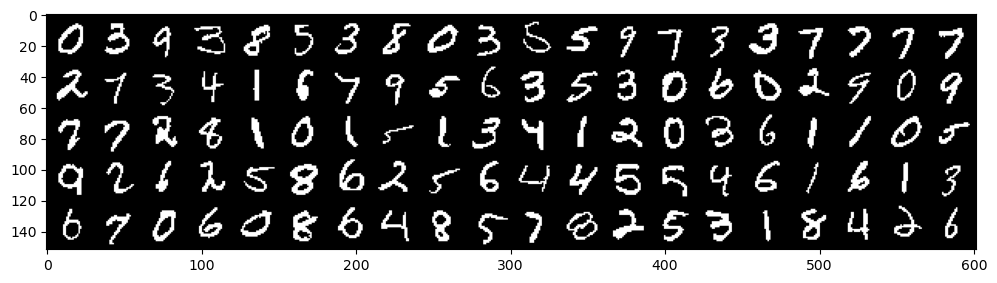

In [3]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [4]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Below, I define a small convolutional network to extract features from the image.
        # The network reduces the input from 28x28 down to 7x7.
        
        # self.encoder_net is a Sequential block that applies the follwoing series of layers:
        # 1) A convolution from 1 input channel to 4 output channels. From the 28x28 images, we get 14x14 images after the convolution
        # 2) A ReLU activation adds non-linearity
        # 3) Another convolution from 4 channels to 8 channels. This further downscales 14x14 to 7x7
        # 4) Another ReLU activation
        
        # Initial X.shape() = (batch_size, 1, 28, 28)
        self.encoder_net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2, padding=1), # X.shape() = (batch_size, 4, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=1), # X.shape() = (batch_size, 8, 7, 7)
            nn.ReLU()
        )
        
        # Now we create two linear layers to produce the parameters of the Normal distribution q(z|x): mu and log sigma
        # Both take as input the 392 features from the reduced images and output D_latent parameters
        self.fc_mu = nn.Linear(8*7*7, D_latent)
        self.fc_log_sigma = nn.Linear(8*7*7, D_latent)

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # We pass the input images through the convolutional layers
        h = self.encoder_net(X) 
        # We flatten the output of the convolutional layers to a vector
        h = h.view(h.size(0), -1) 
        
        # We calculate the mean and the log standard deviation
        # We use the log of sigma and then exponentiating it to ensure positivity and numerical stability
        mu = self.fc_mu(h) 
        log_sigma = self.fc_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # We return a Normal distribution q(z|x)
        return dist.Normal(mu, sigma)


In [5]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # We start from the latent vector, and try to reconstruct the original image.
        # First, we map from the latent dimension back up to a flattened feature map 
        #   we know the encoder reduced the image to a shape of (8,7,7) = 392 features
        #   so we do the reverse: linear layer from D_latent to 392 features.
        self.fc = nn.Linear(D_latent, 8*7*7)

        # self.decoder_net is a Sequential block that applies the follwoing series of layers:
        # 1) A transpose convolution from 8 input channel to 4 output channels. From the 7x7 images, we get 14x14 images after the convolution
        # 2) A ReLU activation adds non-linearity
        # 3) Another transpose convolution from 4 channels to 1 channels. This scales from 14x14 to 28x28
        
        # Initial X.shape() = (batch_size, 8, 7, 7)
        self.decoder_net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1), # X.shape() = (batch_size, 4, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2, padding=1), # X.shape() = (batch_size, 1, 28, 28)
            # We will apply a sigmoid in the forward function to get probabilities
        )
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """
        # We transform the latent vector into a 392-feature vector
        h = self.fc(Z) 
        # We reshape it into size = (batch_size, 8, 7, 7)
        h = h.view(h.size(0), 8, 7, 7) 
        
        # We pass this through the decoder transpose-conv layers
        X_hat = self.decoder_net(h)
        # We pass it through the sigmoid to constrain outputs to [0,1] for the Bernoulli distribution
        X_hat = torch.sigmoid(X_hat)
        
        # We return a Bernoulli distribution p(x|z)
        return dist.Bernoulli(probs=X_hat)



# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [6]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """

    # q(z|x) - We pass the batch of images X through the encoder network
    q_z_x = enc(X)
    
    # We sample a latent vector z from q(z|x), we use rsample() instead of sample() to make sure the sample is differentiable with respect to the parameters
    z = q_z_x.rsample()
    
    # We define the prior distribution p(z) as a standard Normal distribution with mean 0 and variance 1 
    p_z = torch.distributions.Normal(torch.zeros_like(z), torch.ones_like(z))
    
    # We pass the sampled latent z through the decoder to get p(x|z)
    p_x_z = dec(z)
    
    # Compute log probabilities
    # We compute the log probability of z under the standard normal prior (sum over latent dimensions)
    log_p_z = p_z.log_prob(z).sum(dim=1)  
    
    # Similarly, we compute log q(z|x)
    log_q_z_x = q_z_x.log_prob(z).sum(dim=1)
    
    # We compute the log-likelihood of the data X given z (yields a log probability per pixel)
    log_p_x_z = p_x_z.log_prob(X).sum(dim=[1,2,3])
    
    # We calculate the ELBO per datapoint according to the formula
    elbo = log_p_x_z + log_p_z - log_q_z_x
    
    return elbo


# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [7]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [8]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [9]:
# ignore this cell (placeholder)


In [10]:
N_epochs = 20 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 22659.9136
Epoch 1, train loss = 14795.8010
Epoch 2, train loss = 13886.2344
Epoch 3, train loss = 13222.8606
Epoch 4, train loss = 12645.9310
Epoch 5, train loss = 12184.1933
Epoch 6, train loss = 11834.7354
Epoch 7, train loss = 11597.1183
Epoch 8, train loss = 11424.3216
Epoch 9, train loss = 11302.0791
Epoch 10, train loss = 11207.3561
Epoch 11, train loss = 11138.7344
Epoch 12, train loss = 11076.0217
Epoch 13, train loss = 11022.1298
Epoch 14, train loss = 10976.9912
Epoch 15, train loss = 10941.5042
Epoch 16, train loss = 10911.4267
Epoch 17, train loss = 10889.5062
Epoch 18, train loss = 10865.3132
Epoch 19, train loss = 10843.6367


## Do reconstructions look like the input?

Reconstruction accuracy: 0.92


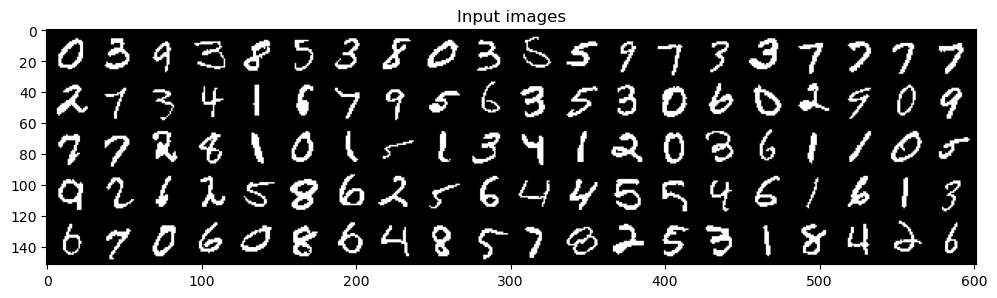

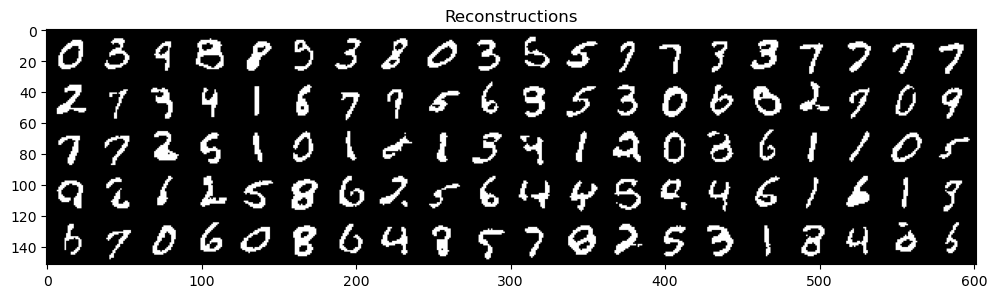

In [11]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

The parameters in both the encoder and decoder are below 10 000 and the digits are readable!

## Do randomly generated samples look coherent?

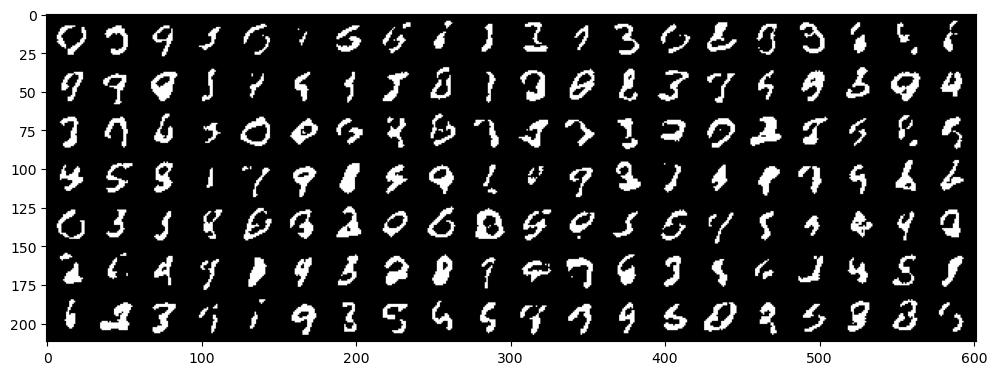

In [12]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

/Users/paulchainieux/anaconda3/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


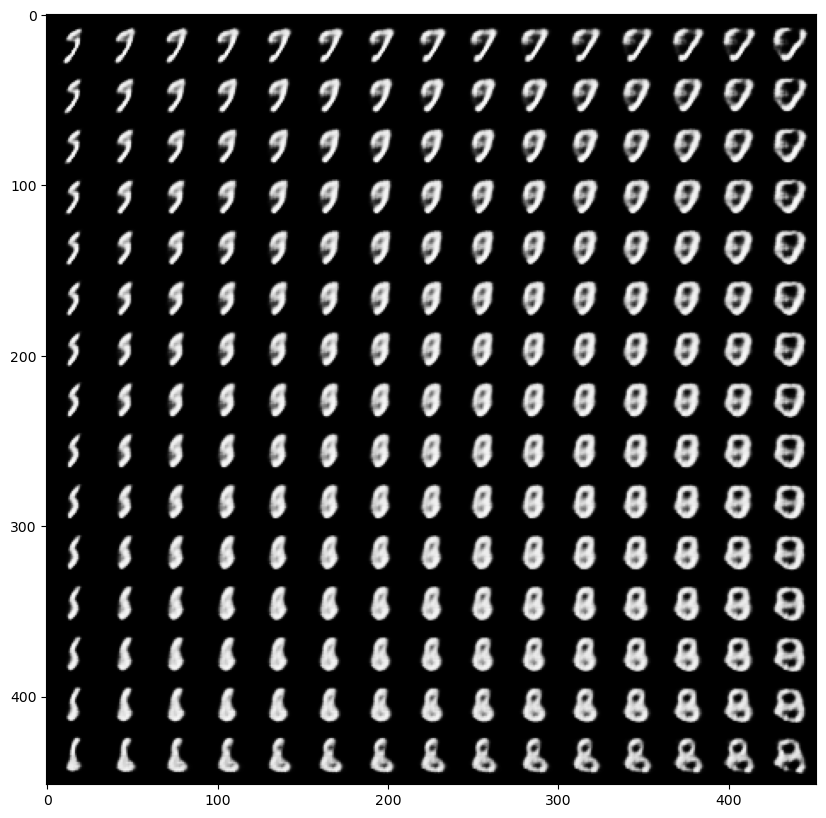

In [13]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [14]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [15]:
# grading


In [16]:
# grading


In [17]:
# grading


In [18]:
# grading


In [19]:
# grading


In [20]:
# grading


In [21]:
# grading
